In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('clean_alternative.csv')
categorical = pd.read_csv('categorical_alternative.csv')
numerical = pd.read_csv('numerical_alternative.csv')
target = pd.read_csv('target.csv')

In [3]:
print(data.shape)
data.head()

(101766, 39)


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,insulin,glyburide-metformin,change,diabetesMed,readmitted
0,1,41,0,1,0,0,0,1,2278392,8222157,Caucasian,Female,5,unknown,unknown,referral,diabetes,unknown,unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NO
1,3,59,0,18,0,0,0,9,149190,55629189,Caucasian,Female,15,emergency,dicharged_to_home,emergency_room,endocrine,diabetes,endocrine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,>30
2,2,11,5,13,2,0,1,6,64410,86047875,AfricanAmerican,Female,25,emergency,dicharged_to_home,emergency_room,pregnancy_complications,diabetes,external_injury,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NO
3,2,44,1,16,0,0,0,7,500364,82442376,Caucasian,Male,35,emergency,dicharged_to_home,emergency_room,other,diabetes,circulatory,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,NO
4,1,51,0,8,0,0,0,5,16680,42519267,Caucasian,Male,45,emergency,dicharged_to_home,emergency_room,neoplasms,neoplasms,diabetes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,NO


#### Columns to be used in the model

- "race" - race of the patient
- "gender" - gender of the patient
- "age" - age bracket of the patient
- "time_in_hospital" - days (from 1 to 14)
- "num_procedures" - number of procedures performed during the hospital stay
- "num_lab_procedures" - number of laboratory procedures performed during the hospital stay
- "num_medications" - number of medications administered during the hospital stay
- "number_outpatient" - number of outpatient visits in the year before a hospital stay
- "number_inpatient" - number of inpatient visits in the year before the hospital stay
- "number_emergency" - number of visits to the emergency room in the year before the hospital stay
- "number_diagnoses"  - number of diagnosis
- "admission_type_id" - admission type
- "discharge_disposition_id" - discharge type
- "admission_source_id" - admission source
- "diag_1" - primary diagnosis 
- "diag_2" - secondary diagnosis
- "diag_3" - additional secondary diagnosis
- "glucose_test" - whether the glucose serum came out as high 2, normal 1, or not performed 0
- "A1Cresult" - whether the A1C level of the patient came out as high 2, normal 1, or not performed 0
- "change" - whether there was a change in the diabetes medication ('yes' or 'no')
- "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')
- "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no')

- readmitted column, I will convert it to 0-1

In [4]:
df = data.copy()

In [5]:
df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [6]:
df['readmitted'] = np.where(df['readmitted'].isin(['<30','>30']) , 1 , 0)

In [7]:
df['readmitted'].value_counts()

0    54864
1    46902
Name: readmitted, dtype: int64

- encounter_id and patient_nbr columns
- some patients came more than once, so they effect readmitted column positive values
- so i will drop duplicated in patient id column but going to keep one

In [8]:
df = df.drop_duplicates(['patient_nbr'], keep = 'last')

- discharge disposition id columns has a category for ex patients, I will drop them

In [9]:
# I will drop rows of expired patients
df = df[df['discharge_disposition_id'] != 'expired']
df.shape

(69879, 39)

- I will drop encounter_id and patient_nbr columns since I won't user them in my model

In [10]:
df = df.drop(columns = ['encounter_id','patient_nbr'])

### goint to check some correlations between categoricals

- there are some high correlations between some test results, so I checked and decided to drop that columns
- after I drop the columns, I looked at chi2 contingency values and continue for the models
- 'change', 'diabetesMed'  >> even though they are highly correlated, I have to keep them in my model

In [11]:
drop_cols =  ['acetohexamide', 'tolbutamide', 'miglitol', 'chlorpropamide','glyburide-metformin','glimepiride',
             'glipizide', 'glyburide', 'rosiglitazone','nateglinide','pioglitazone','repaglinide','acarbose', 
              'metformin','max_glu_serum', 'insulin']

In [12]:
df = df.drop(columns = drop_cols)

In [13]:
df.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'diag_1', 'diag_2', 'diag_3', 'A1Cresult', 'change', 'diabetesMed',
       'readmitted'],
      dtype='object')

In [14]:
list1 = ('change', 'diabetesMed', 'readmitted')
list2 = ('change', 'diabetesMed', 'readmitted')

In [15]:
list_prod = list(product(list1,list2, repeat = 1))

In [16]:
import scipy.stats as ss
result = []
for i in list_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(    pd.crosstab(     df[i[0]]  , df[i[1]])))   [1]      )     )

In [17]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])

In [18]:
abc = chi_test_output.pivot(index='var1', columns='var2', values='coeff')

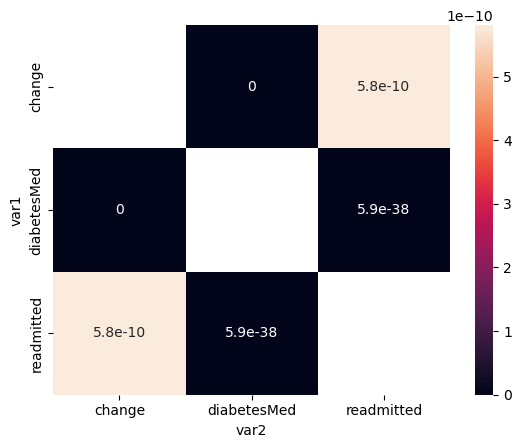

In [19]:
sns.heatmap(abc, annot=True)
plt.show()

#### Fixing the imbalance with undersampling

In [20]:
df['readmitted'].value_counts()

0    52735
1    17144
Name: readmitted, dtype: int64

In [21]:
# X/y split
X = df.drop('readmitted',axis = 1)
y = df['readmitted']

In [22]:
# train-test-split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # default fraction is .2

In [23]:
X_train_imb = pd.DataFrame(X_train)

In [24]:
trainset = pd.concat((X_train, y_train), axis=1)

In [25]:
trainset['readmitted'].value_counts()

0    39604
1    12805
Name: readmitted, dtype: int64

I will balance my data with downsampling

In [26]:
from sklearn.utils import resample

category_0 = trainset[trainset['readmitted'] == 0]
category_1 = trainset[trainset['readmitted'] == 1]

In [27]:
category_0_undersampled = resample(category_0, 
                                   replace=False, 
                                   n_samples = len(category_1))

In [28]:
train_undersampled = pd.concat([category_0_undersampled, category_1], axis=0)

In [29]:
train_undersampled = train_undersampled.sample(frac =1)

In [30]:
train_undersampled['readmitted'].value_counts()

0    12805
1    12805
Name: readmitted, dtype: int64

In [31]:
X_train = train_undersampled.drop('readmitted',axis = 1)
y_train = train_undersampled['readmitted']

## Models

In [32]:
#splitting into categorical and numerical
X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)

X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object)

In [33]:
#scale numericals
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(X_train_num) 
numericals_train_scaled = transformer.transform(X_train_num)
numericals_test_scaled = transformer.transform(X_test_num)

In [34]:
#encode categoricals
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', drop='first').fit(X_train_cat)
categoricals_train_encoded = encoder.transform(X_train_cat).toarray()
categoricals_test_encoded = encoder.transform(X_test_cat).toarray()

In [35]:
X_train = np.concatenate((numericals_train_scaled,categoricals_train_encoded),axis=1)
X_test = np.concatenate((numericals_test_scaled,categoricals_test_encoded),axis=1)
X_train = pd.DataFrame(X_train)

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='saga')
LR.fit(X_train, y_train)
LR_score_train = LR.score(X_train,y_train)
LR_score_test = LR.score(X_test, y_test) 

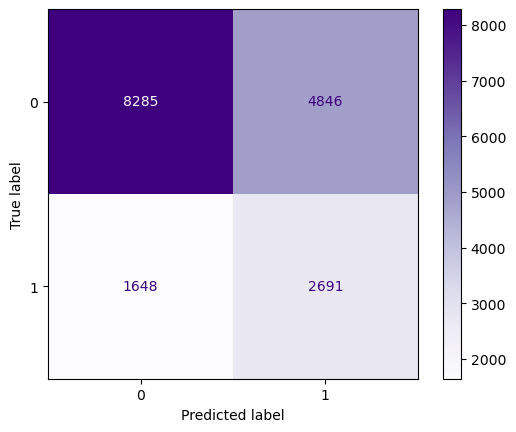

In [37]:
pred_LR = LR.predict(X_test)
array_LR = confusion_matrix(y_test,pred_LR)
plot_confusion_matrix(LR, X_test, y_test,cmap=plt.cm.Purples)  
plt.show()

In [38]:
print("model score: ", LR.score(X_test, y_test))
print("precision: ",precision_score(y_test,pred_LR))    # true pos / true pos+false pos
print("recall: ",recall_score(y_test,pred_LR))    #  true pos/true pos + false neg
print("f1: ",f1_score(y_test,pred_LR))

model score:  0.6282770463651974
precision:  0.35703860952633676
recall:  0.6201889836367827
f1:  0.4531828898619064


### Random Forest Classifier

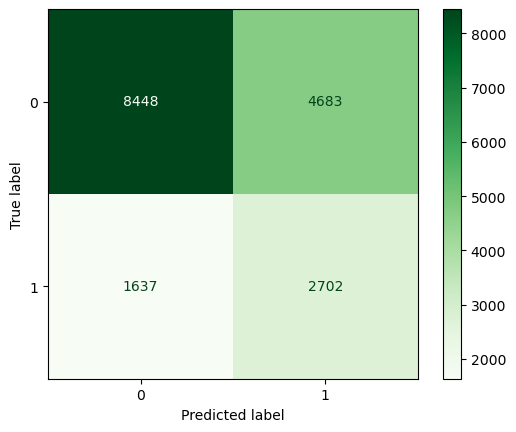

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X_train, y_train)
clf_score_train = clf.score(X_train,y_train)
clf_score_test = clf.score(X_test, y_test) 

pred_clf = clf.predict(X_test)
clf_array = confusion_matrix(y_test,pred_clf)
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Greens)  
plt.show()

In [40]:
print("model score: ", clf.score(X_test, y_test))
print("precision: ",precision_score(y_test,pred_clf))    # true pos / true pos+false pos
print("recall: ",recall_score(y_test,pred_clf))    #  true pos/true pos + false neg
print("f1: ",f1_score(y_test,pred_clf))

model score:  0.6382369776760161
precision:  0.36587677725118484
recall:  0.6227241299838673
f1:  0.46093483452746503


#### Decision Tree Classifier

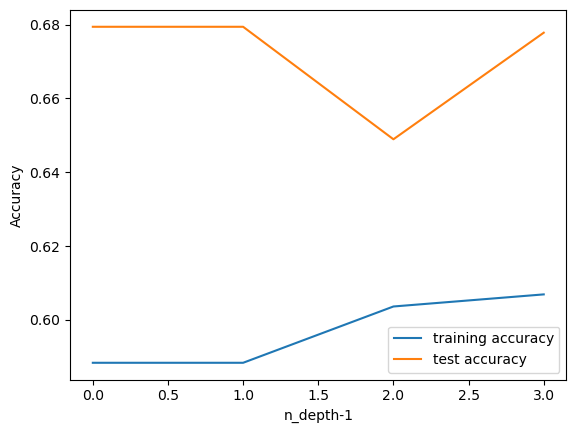

In [41]:
from sklearn.tree import DecisionTreeClassifier
# I want to find optimal depth for the model
max_depth = range(1,5)
test = []
train = []

for depth in max_depth:
    DT = DecisionTreeClassifier(max_depth=depth, random_state=0)
    DT.fit(X_train, y_train)
    test.append(DT.score(X_test,y_test))
    train.append(DT.score(X_train,y_train)) 
    
# we quickly see overfitting properties
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth-1")
plt.legend()

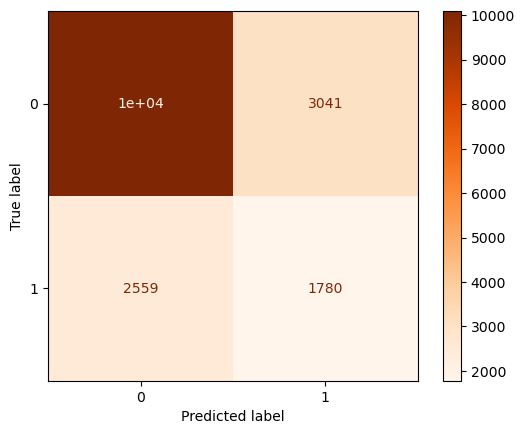

In [42]:
DT = DecisionTreeClassifier(max_depth=2)
DT.fit(X_train, y_train)

DT_score_train = DT.score(X_train,y_train)
DT_score_test = DT.score(X_test, y_test) 

pred_DT = DT.predict(X_test)
DT_array = confusion_matrix(y_test,pred_DT)
plot_confusion_matrix(DT, X_test, y_test,cmap=plt.cm.Oranges)  
plt.show()

In [43]:
print("model score: ", DT.score(X_test, y_test))
print("precision: ",precision_score(y_test,pred_DT))    # true pos / true pos+false pos
print("recall: ",recall_score(y_test,pred_DT))    #  true pos/true pos + false neg
print("f1: ",f1_score(y_test,pred_DT))

model score:  0.6794504865483686
precision:  0.3692180045633686
recall:  0.4102327725282323
f1:  0.388646288209607


### Comparing models

- comparing my models with cross validation

In [44]:
model1 = clf
model2 = LR
model3 = DT

model_pipeline = [model1, model2, model3]
model_names = ['RandomForestClassifier', 'Logistic Regression', 'Decision Tree Classifier']
scores = {}
for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    scores[model_name] = mean_score
print(scores)

{'RandomForestClassifier': 0.6357282311597032, 'Logistic Regression': 0.620929324482624, 'Decision Tree Classifier': 0.5883248730964467}


### I will choose my RandomForestClassifier Model since accuracy is higher

- Now I will apply the model to my dataset

In [45]:
df_whole = data.copy()

In [46]:
# df_whole = df_whole.drop_duplicates(['patient_nbr'], keep = 'last')  >>> I was not sure to drop this rows and left them in because it is the main data in the end
# I will drop rows of expired patients
df_whole = df_whole[df_whole['discharge_disposition_id'] != 'expired']
df_whole = df_whole.drop(columns = ['encounter_id','patient_nbr','acetohexamide', 'tolbutamide', 'miglitol', 'chlorpropamide','glyburide-metformin','glimepiride',
             'glipizide', 'glyburide', 'rosiglitazone','nateglinide','pioglitazone','repaglinide','acarbose', 
              'metformin','max_glu_serum', 'insulin'])
df_whole['readmitted'] = np.where(df_whole['readmitted'].isin(['<30','>30']) , 1 , 0)

print(df_whole.shape)
df_whole.head(5)

(100114, 21)


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,A1Cresult,change,diabetesMed,readmitted
0,1,41,0,1,0,0,0,1,Caucasian,Female,5,unknown,unknown,referral,diabetes,unknown,unknown,0,0,0,0
1,3,59,0,18,0,0,0,9,Caucasian,Female,15,emergency,dicharged_to_home,emergency_room,endocrine,diabetes,endocrine,0,1,1,1
2,2,11,5,13,2,0,1,6,AfricanAmerican,Female,25,emergency,dicharged_to_home,emergency_room,pregnancy_complications,diabetes,external_injury,0,0,1,0
3,2,44,1,16,0,0,0,7,Caucasian,Male,35,emergency,dicharged_to_home,emergency_room,other,diabetes,circulatory,0,1,1,0
4,1,51,0,8,0,0,0,5,Caucasian,Male,45,emergency,dicharged_to_home,emergency_room,neoplasms,neoplasms,diabetes,0,1,1,0


In [47]:
df_whole.to_csv('df_whole.csv', index = False)

In [48]:
# X/y split
X = df_whole.drop('readmitted',axis = 1)
y = df_whole['readmitted']

In [49]:
#splitting into categorical and numerical
X_num = X.select_dtypes(include = np.number)
X_cat = X.select_dtypes(include = object)

In [50]:
numerical_scaled = transformer.transform(X_num)
numerical_scaled = pd.DataFrame(numerical_scaled)

In [51]:
categorical_encoded = encoder.transform(X_cat).toarray()
categorical_encoded = pd.DataFrame(categorical_encoded)

In [52]:
X = np.concatenate((numerical_scaled,categorical_encoded),axis=1)

model score:  0.7033182172323551
precision:  0.6850497052115161
recall:  0.6787983454863332
f1:  0.6819096984235777


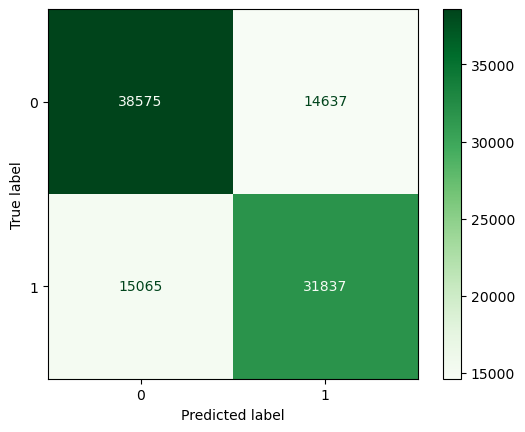

In [53]:
clf_score = clf.score(X,y)
# print(clf_score) 
pred_whole = clf.predict(X)
print("model score: ", clf.score(X, y))
print("precision: ",precision_score(y,pred_whole))    # true pos / true pos+false pos
print("recall: ",recall_score(y,pred_whole))    #  true pos/true pos + false neg
print("f1: ",f1_score(y,pred_whole))

clf_array_whole = confusion_matrix(y,pred_whole)
plot_confusion_matrix(clf, X, y,cmap=plt.cm.Greens)  
plt.show()

### Result

- When I apply my model above, it was able to predict readmissions with %70 accuracy 
- Hospital wanted to make follow-up calls to patients who are likely to be readmitted

## Some More Analysis

- What is the most common primary diagnosis by age group?

- Reminder: Age is mapped to mean value in the range, for example 35 means age between 30-40
- Until the age of 40 primary diagnosis is diabetes
- Age of 40 and above primary diagnosis is circulatory

In [54]:
df_whole['age'].value_counts()

75    25562
65    22185
55    17102
85    16706
45     9626
35     3765
95     2668
25     1650
15      690
5       160
Name: age, dtype: int64

In [55]:
age = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]

In [56]:
for i in age:
    print('for age group: ', i , 'primary diagnosis is: ', df_whole.loc[df_whole['age'] == i]['diag_1'].value_counts()[:1].sort_values(ascending=False))

for age group:  5 primary diagnosis is:  diabetes    135
Name: diag_1, dtype: int64
for age group:  15 primary diagnosis is:  diabetes    475
Name: diag_1, dtype: int64
for age group:  25 primary diagnosis is:  diabetes    677
Name: diag_1, dtype: int64
for age group:  35 primary diagnosis is:  diabetes    905
Name: diag_1, dtype: int64
for age group:  45 primary diagnosis is:  circulatory    1877
Name: diag_1, dtype: int64
for age group:  55 primary diagnosis is:  circulatory    5071
Name: diag_1, dtype: int64
for age group:  65 primary diagnosis is:  circulatory    7448
Name: diag_1, dtype: int64
for age group:  75 primary diagnosis is:  circulatory    8943
Name: diag_1, dtype: int64
for age group:  85 primary diagnosis is:  circulatory    5342
Name: diag_1, dtype: int64
for age group:  95 primary diagnosis is:  circulatory    803
Name: diag_1, dtype: int64


- Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates.

- When I check the readmission positive values, I see that instead of diabetes, cirtculatory problems are higher
- But we must consider these people have diabetes too, if we think diabetes causes circulatory problems, then yes diabetes is playing a central role in readmission

In [57]:
df_diabetes = df_whole[['diag_1','diag_2','diag_3','readmitted']]

In [58]:
df_diabetes = df_diabetes.loc[df_diabetes['readmitted'] == 1]

In [59]:
cols = ['diag_1', 'diag_2', 'diag_3']
for col in cols:
    print(df_diabetes[col].value_counts()[:3].sort_values(ascending=False))

circulatory    14324
respiratory     6935
diabetes        4455
Name: diag_1, dtype: int64
circulatory    15174
diabetes        5551
respiratory     5209
Name: diag_2, dtype: int64
circulatory    14269
diabetes        7635
endocrine       3916
Name: diag_3, dtype: int64


- On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?

- Age above 50, 
- Patient who is admitted to emergency room, 
- Patient with circulatory complaint-diagnosis,
- Patient who stayed in the hospital between 3-5 days,
- Patient who is discharged to home  >>> are most likely to come back

In [60]:
readmitted_positive = df_whole.loc[df_whole['readmitted'] == 1]

In [61]:
readmitted_positive

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,diag_1,diag_2,diag_3,A1Cresult,change,diabetesMed,readmitted
1,3,59,0,18,0,0,0,9,Caucasian,Female,15,emergency,dicharged_to_home,emergency_room,endocrine,diabetes,endocrine,0,1,1,1
5,3,31,6,16,0,0,0,9,Caucasian,Male,55,urgent,dicharged_to_home,referral,circulatory,circulatory,diabetes,0,0,1,1
7,5,73,0,12,0,0,0,8,Caucasian,Male,75,emergency,dicharged_to_home,emergency_room,circulatory,respiratory,diabetes,0,0,1,1
10,9,47,2,17,0,0,0,9,AfricanAmerican,Female,45,emergency,dicharged_to_home,emergency_room,diabetes,circulatory,injury_poisoning,0,0,1,1
11,7,62,0,11,0,0,0,7,AfricanAmerican,Male,65,urgent,dicharged_to_home,transfer_from_a_hospital,neoplasms,blood,neoplasms,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,9,50,2,33,0,0,0,9,Caucasian,Female,75,emergency,dicharged_to_home,emergency_room,digestive,digestive,diabetes,2,1,1,1
101755,14,73,6,26,0,1,0,9,other,Female,45,emergency,dicharged_to_home,emergency_room,genitourinary,genitourinary,respiratory,2,1,1,1
101756,2,46,6,17,1,1,1,9,other,Female,65,emergency,dicharged_to_home,emergency_room,injury_poisoning,genitourinary,circulatory,0,0,1,1
101760,6,45,1,25,3,1,2,9,AfricanAmerican,Female,65,emergency,dicharged_to_home,emergency_room,nervous_system,circulatory,circulatory,0,1,1,1


In [62]:
for col in readmitted_positive:
    print(readmitted_positive[col].value_counts()[:3].sort_values(ascending=False))

3    7979
2    7631
4    6708
Name: time_in_hospital, dtype: int64
43    1337
1     1308
44    1170
Name: num_lab_procedures, dtype: int64
0    22516
1     9558
2     5641
Name: num_procedures, dtype: int64
13    2892
15    2789
12    2781
Name: num_medications, dtype: int64
0    37115
1     4904
2     2160
Name: number_outpatient, dtype: int64
0    39673
1     4552
2     1370
Name: number_emergency, dtype: int64
0    26034
1    10690
2     4913
Name: number_inpatient, dtype: int64
9    25026
8     5052
7     4851
Name: number_diagnoses, dtype: int64
Caucasian          35716
AfricanAmerican     8789
other               2397
Name: race, dtype: int64
Female    25670
Male      21232
Name: gender, dtype: int64
75    12544
65    10399
85     8301
Name: age, dtype: int64
emergency    25533
urgent        8518
elective      7707
Name: admission_type_id, dtype: int64
dicharged_to_home                27174
dichr_to_another_hosp            10346
dichr_to_home_w_healthservice     7053
Name: discha

In [63]:
readmitted_positive.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'diag_1', 'diag_2', 'diag_3', 'A1Cresult', 'change', 'diabetesMed',
       'readmitted'],
      dtype='object')

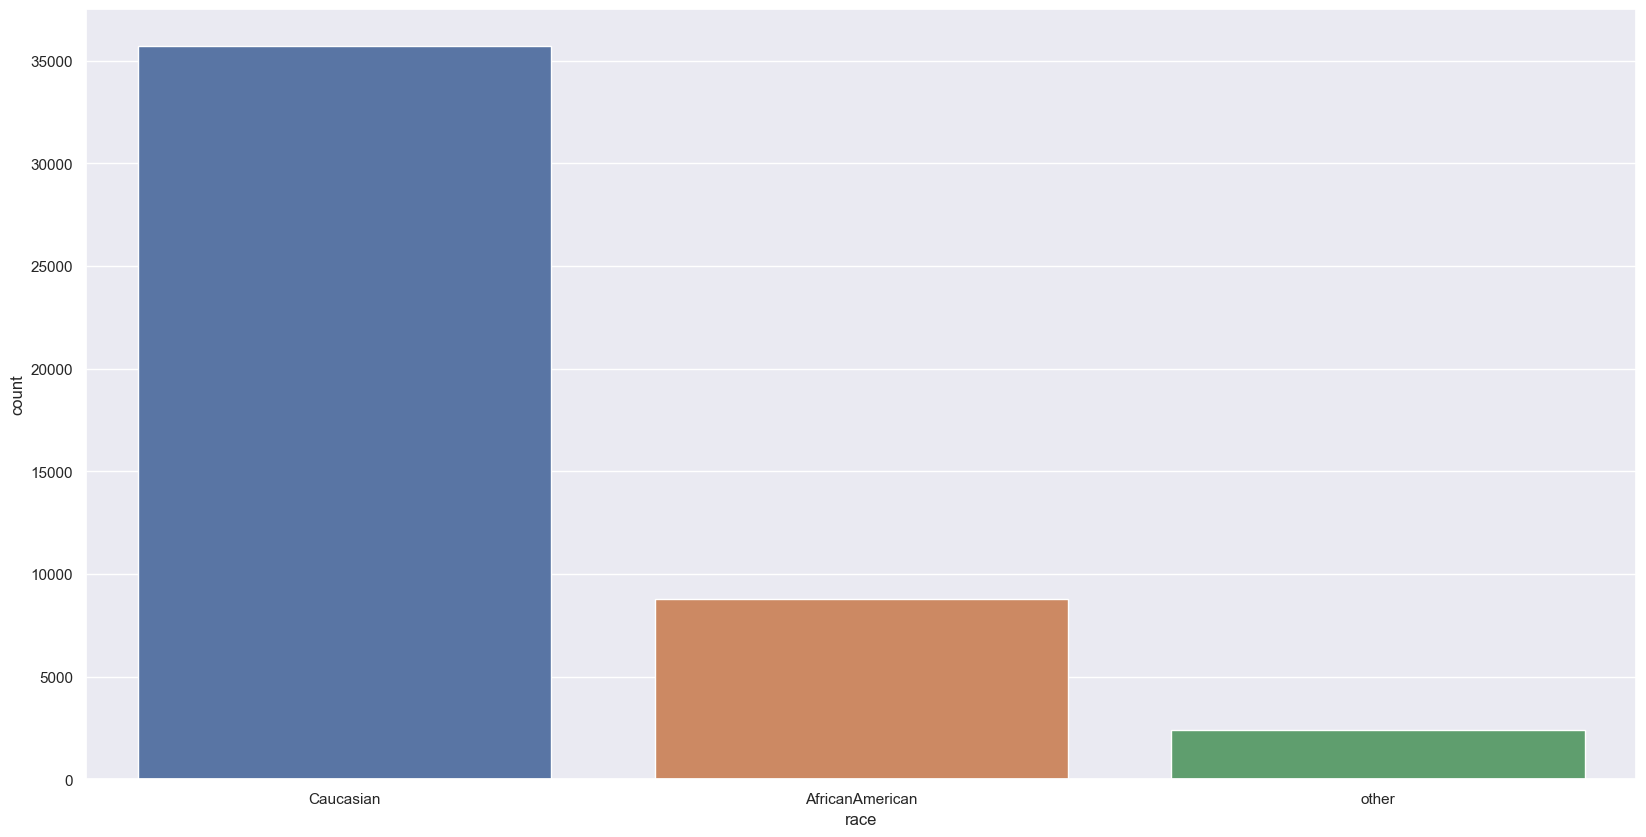

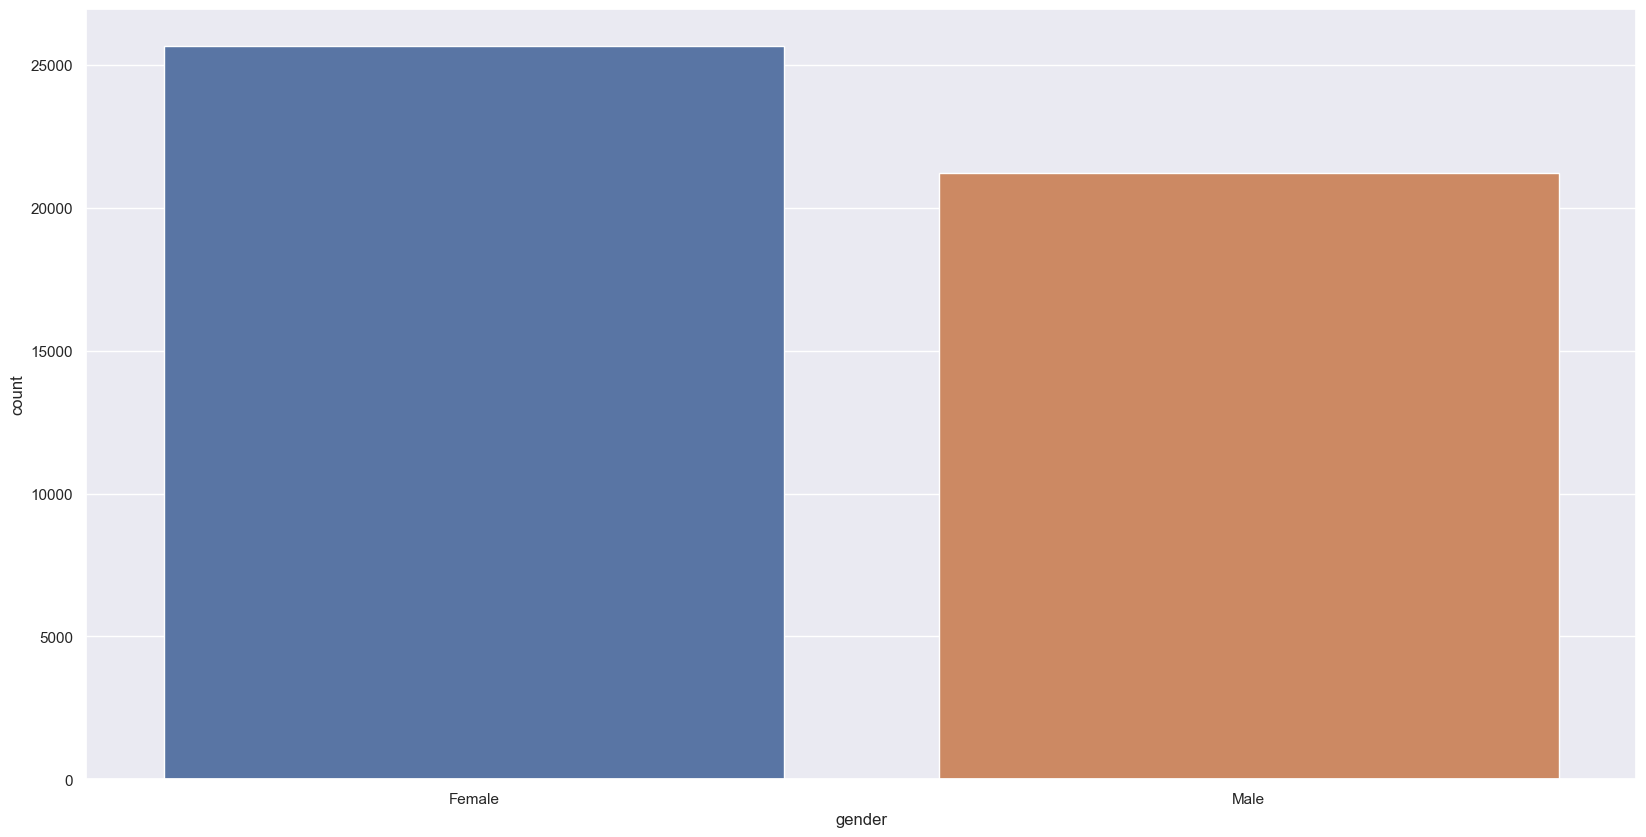

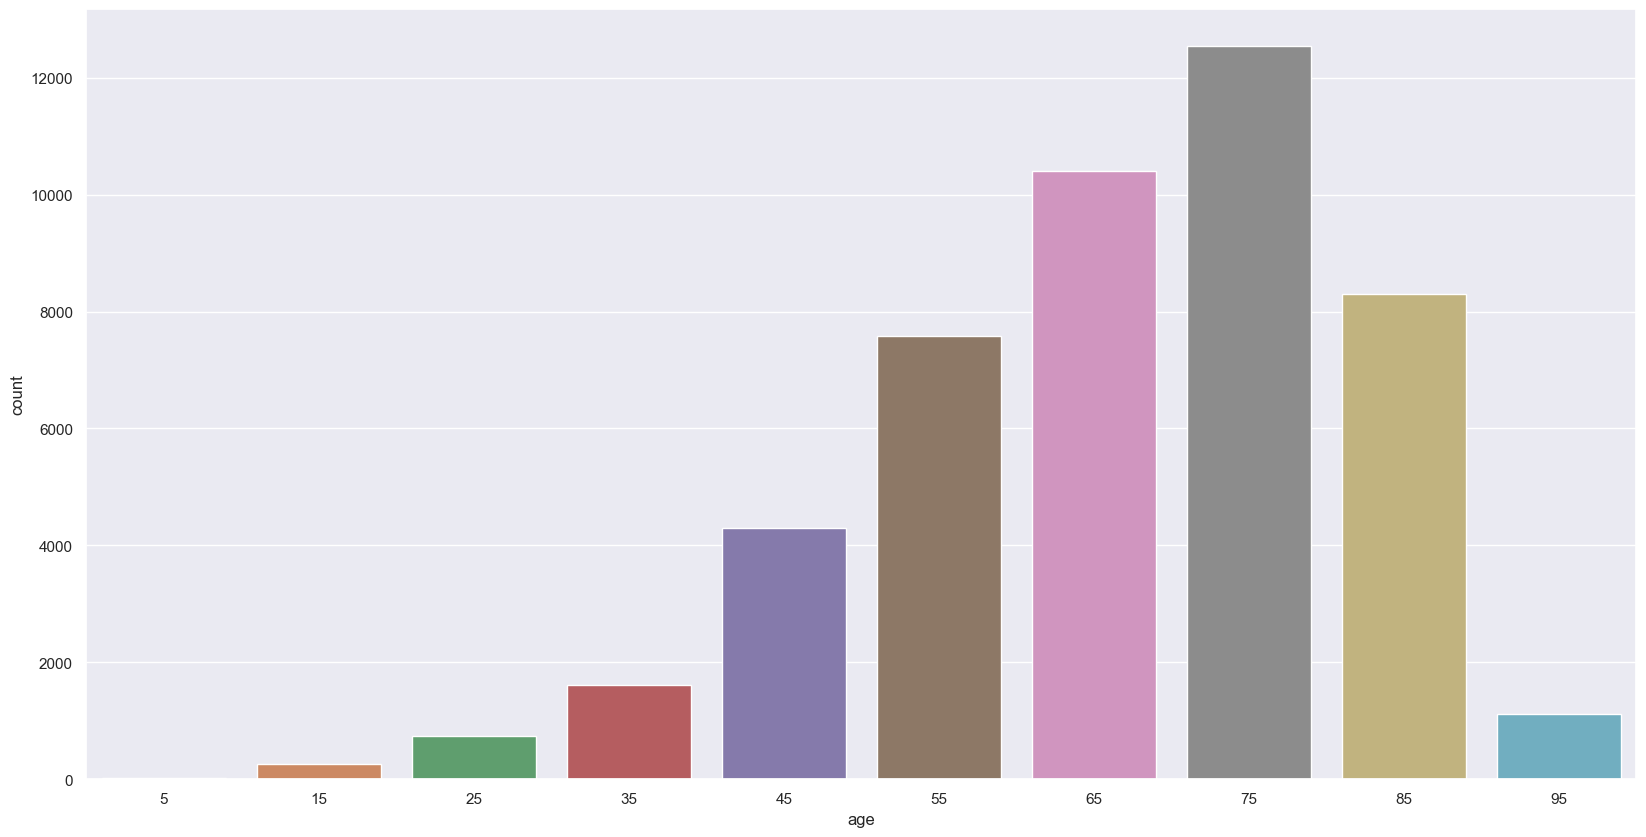

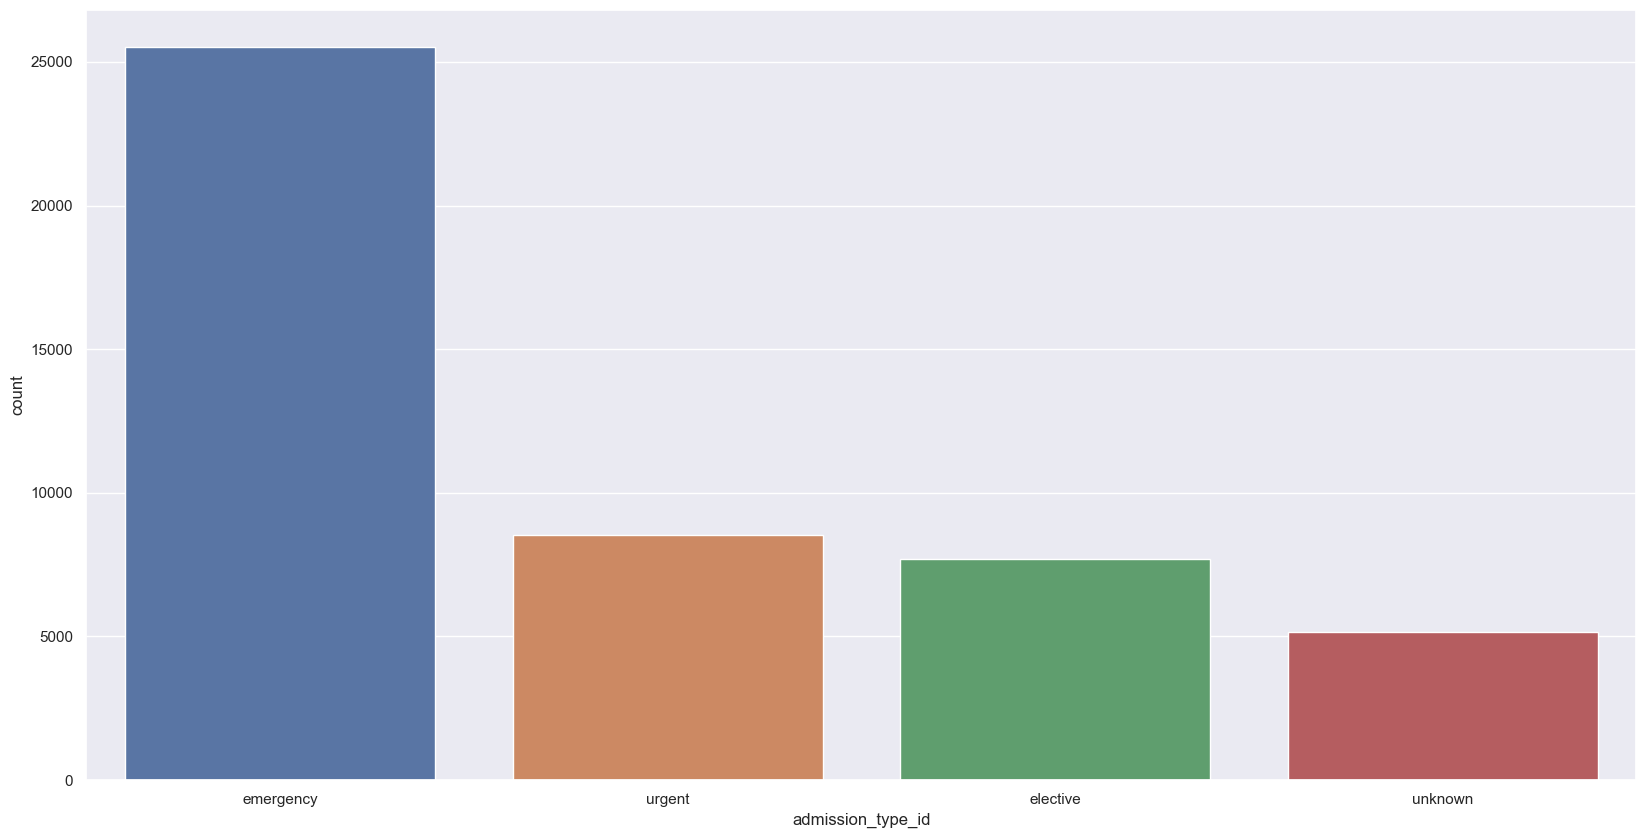

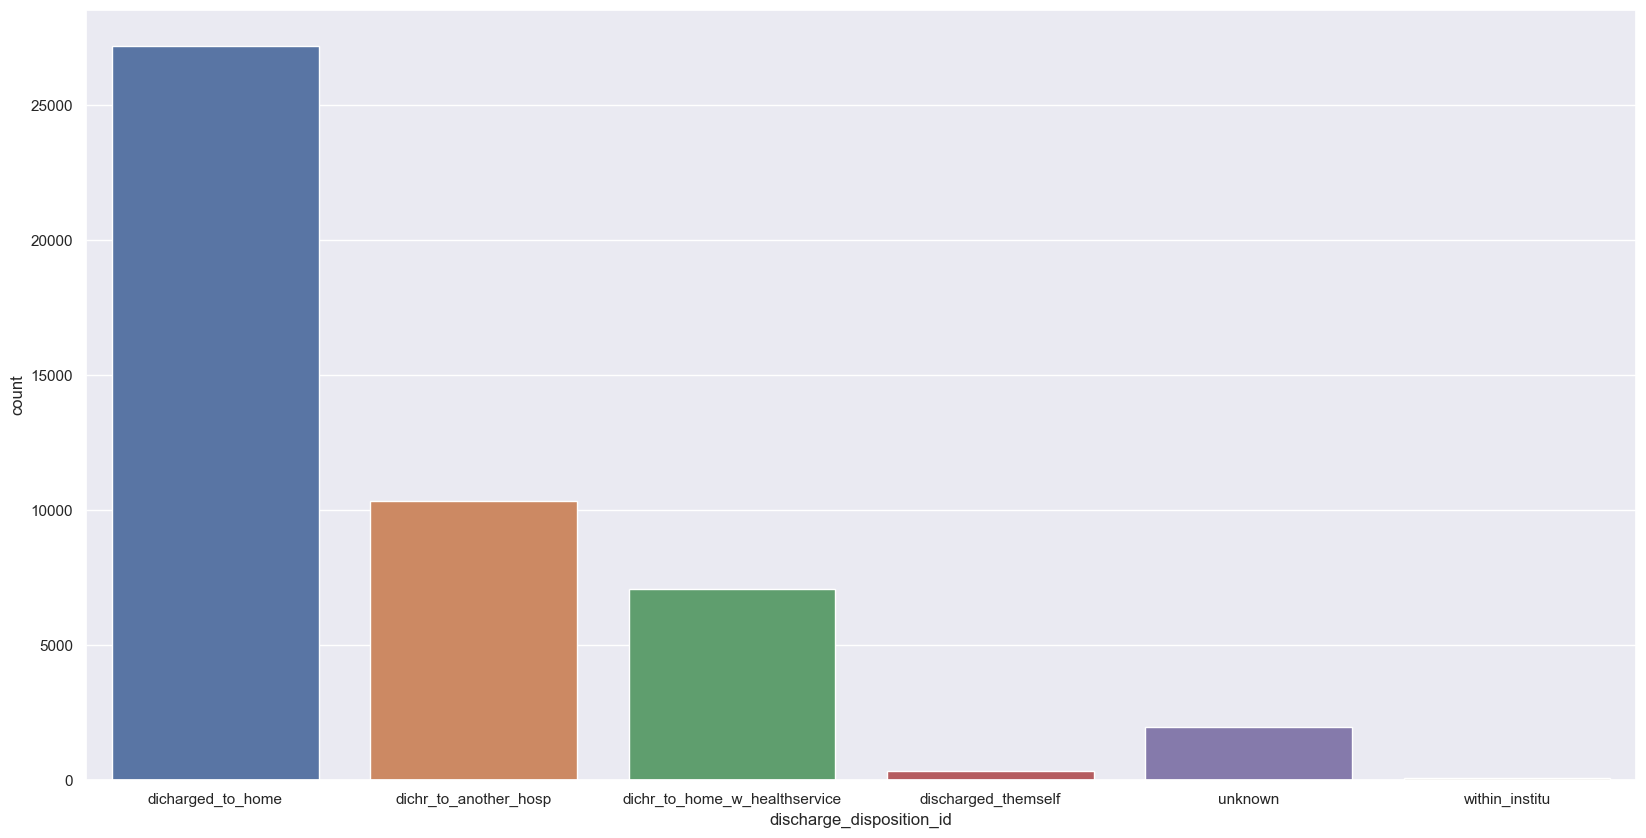

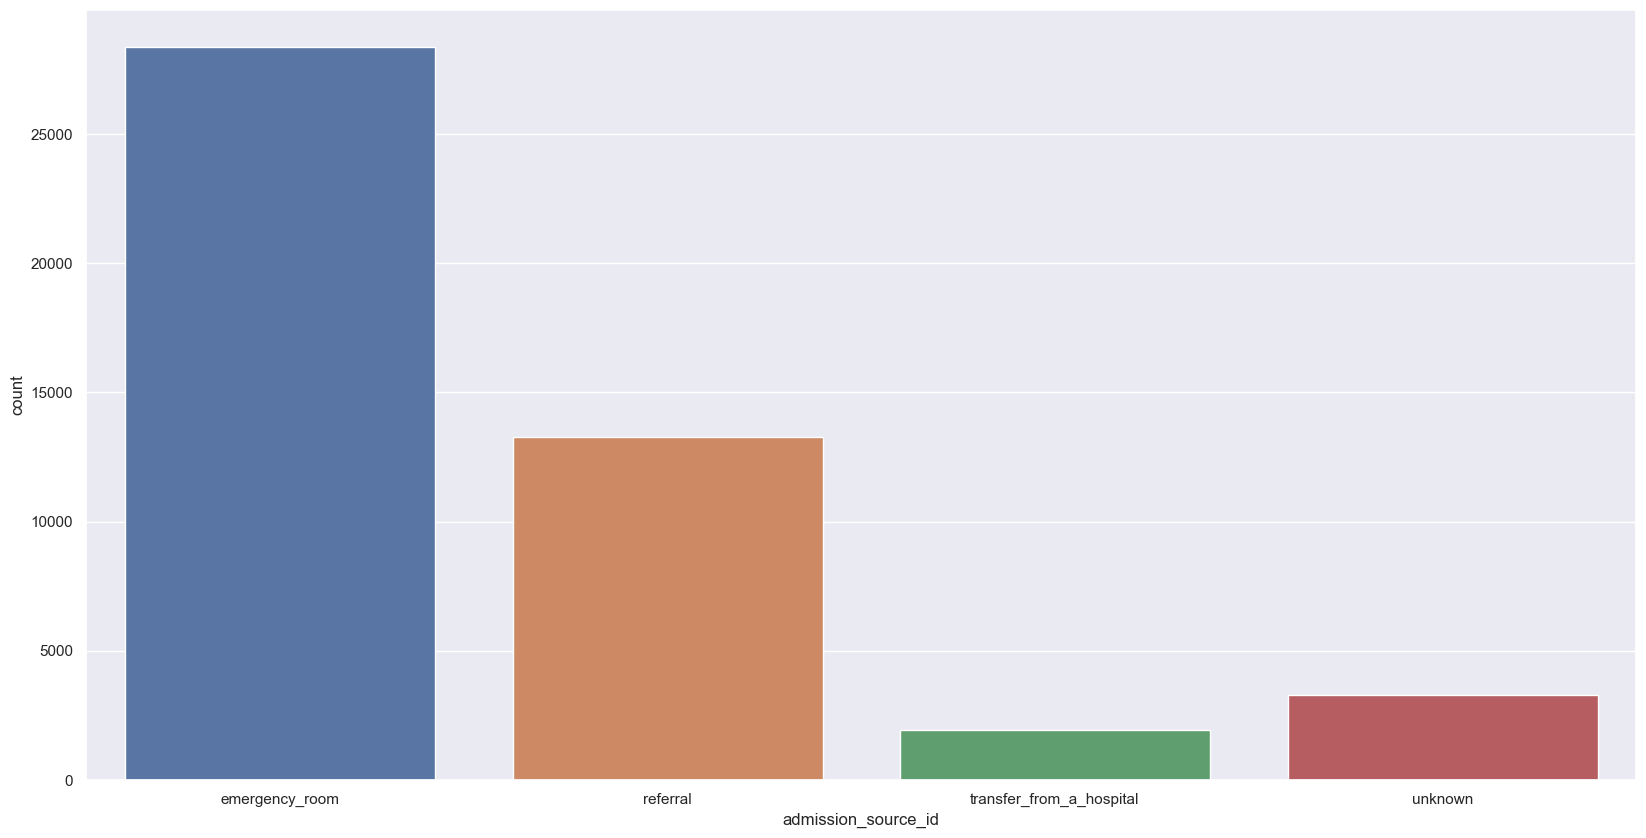

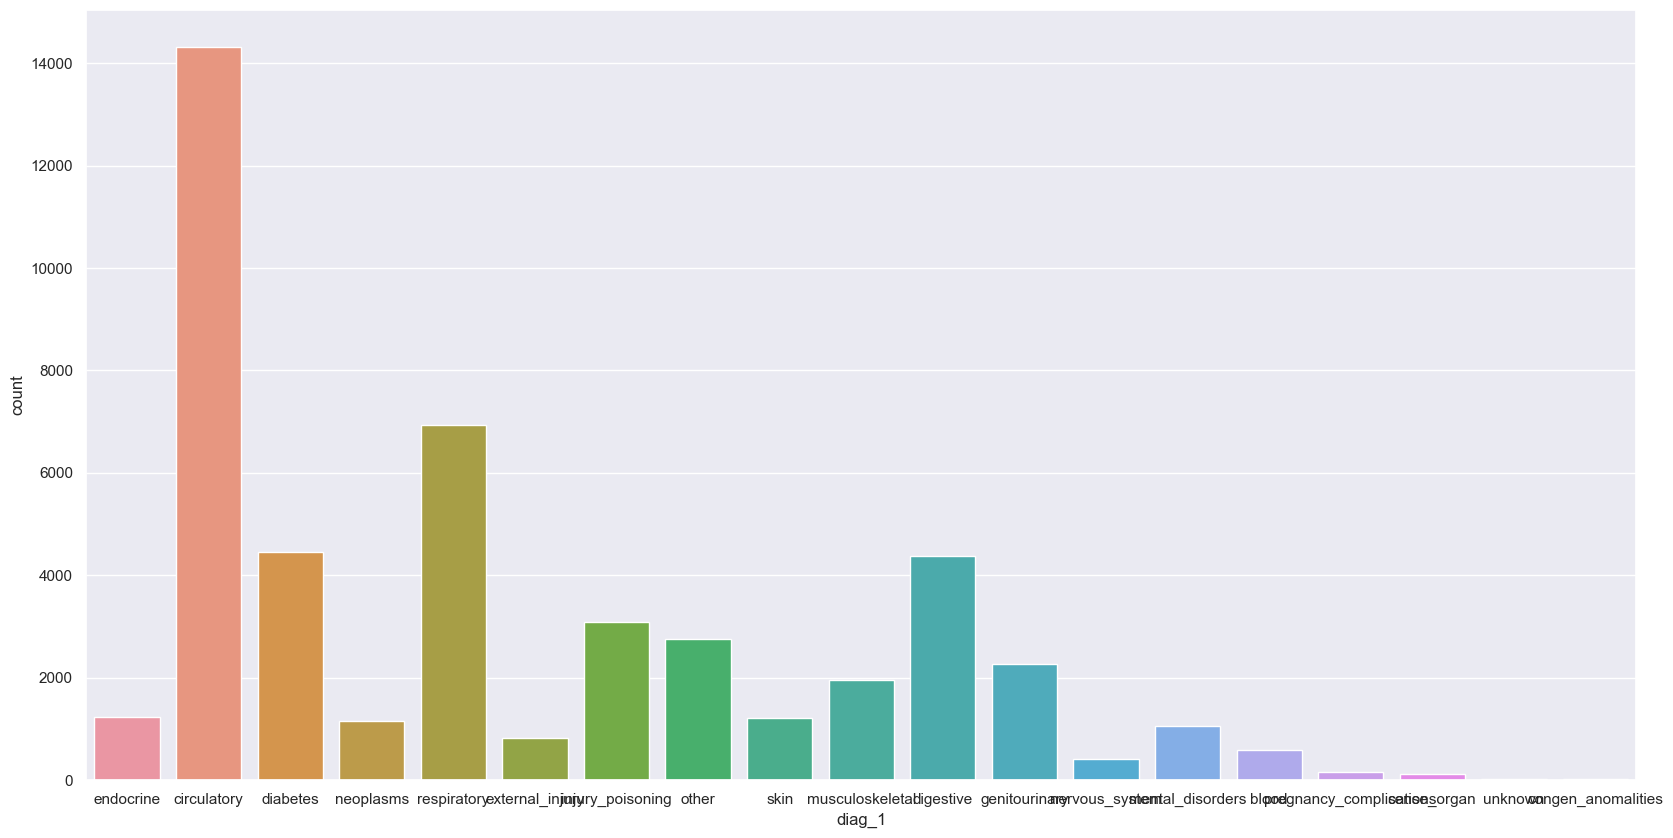

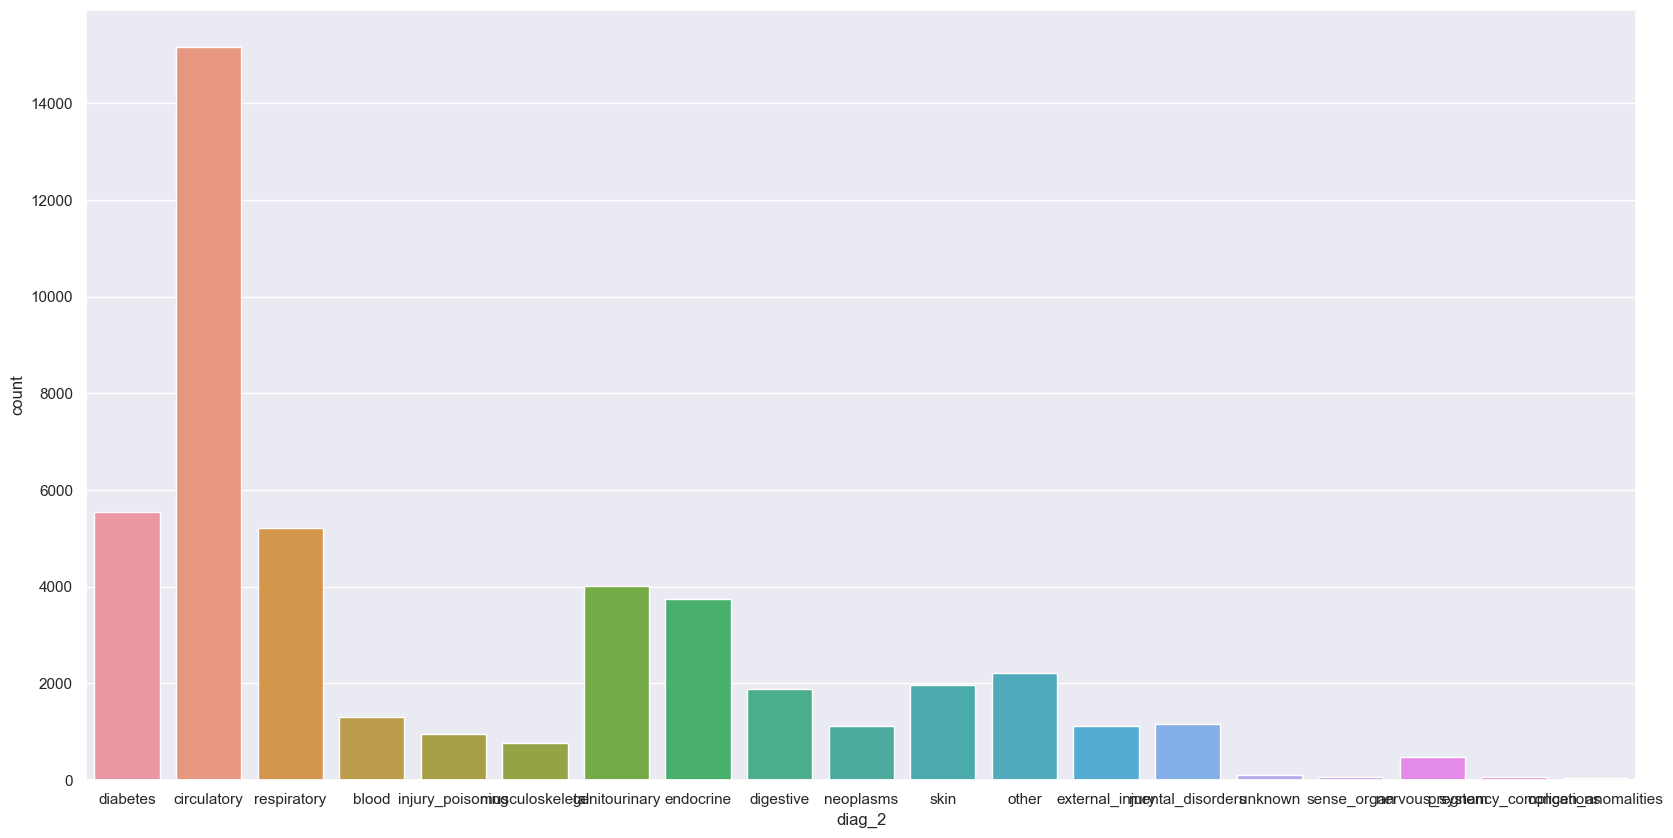

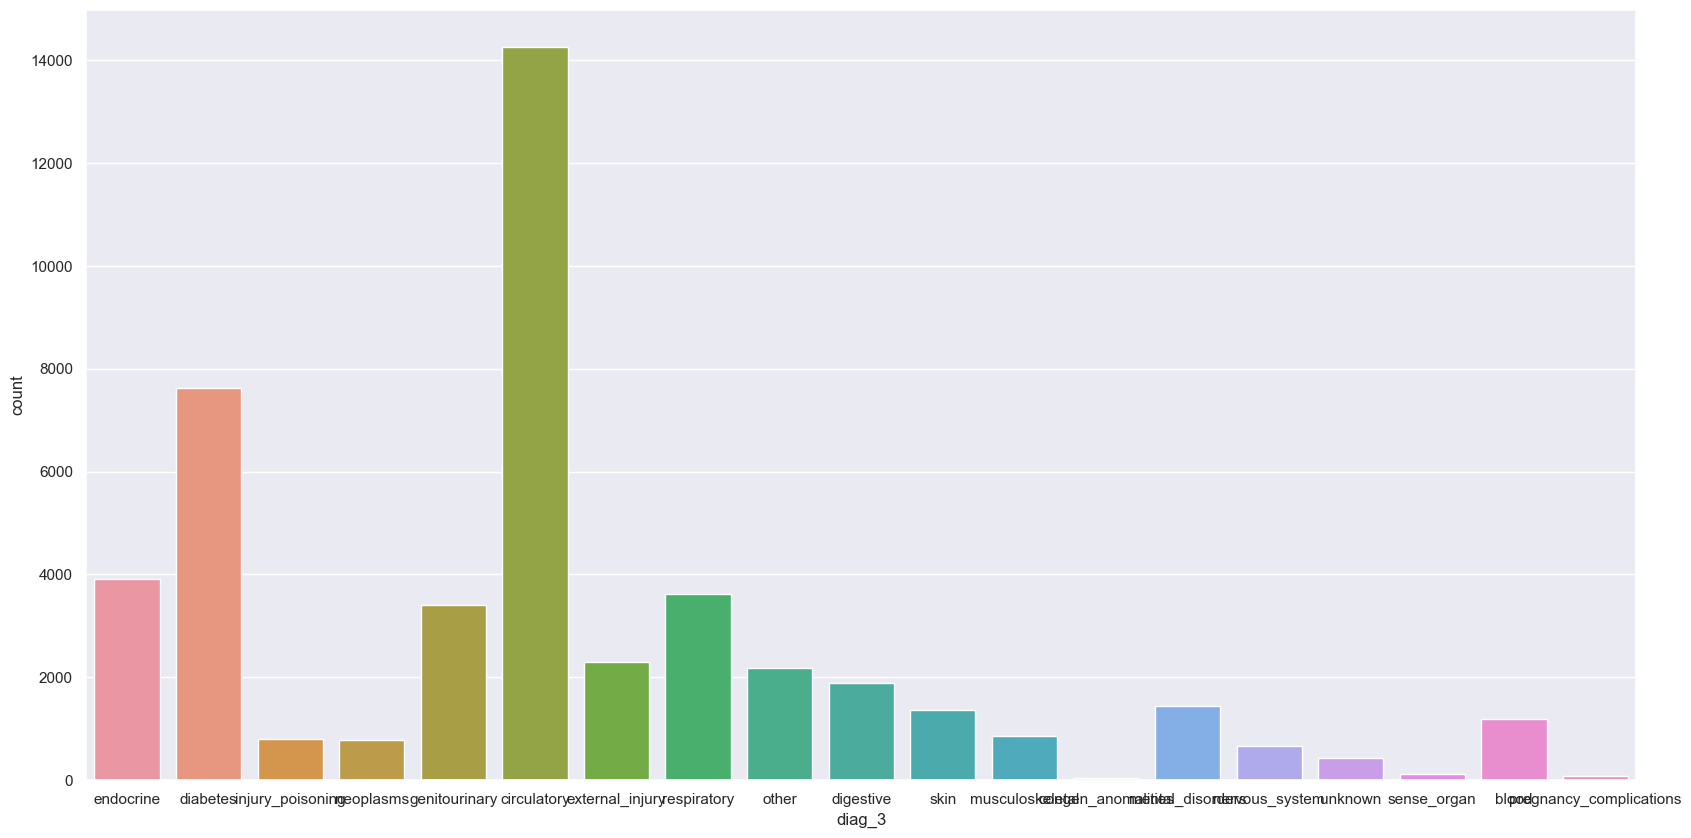

In [64]:
cols = ['race', 'gender', 'age','admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'diag_1', 'diag_2', 'diag_3']
for col in cols:
    sns.set(rc={'figure.figsize': (20, 10)})
    sns.countplot(data=readmitted_positive, x=col)
    plt.show()